# Capstone Project - The Battle of Neighborhoods (Week 2)
### Applied Data Science Capstone - IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Results](#results)
* [Discussion](#discussion)
* [Conclusion](#conclusion)

## Introduction: Business Problem<a name="introduction"></a>
A real estate development and investment company is trying to identify and shortlist retail opportunities in the **Greater Toronto** area based on trends and popularity. The company realizes the importance and relevance of social media in understanding the pulse of the market and seeks to use data as a key driver in decision making.

How can the company use social trends to select popular venues, understand and identify characteristics of the venues, and select new locations with similar characteristics which would have high growth potential?

In this study, as a Data Scientist, I provide a point of view of how data can be acquired, cleansed, curated and analyzed through machine learning technique to better drive the decision-making process.

## Data<a name="data"></a>
To drive the understanding and analysis in this data science project, I have used the following data sets:
1.	**Toronto neighborhoods data** from [Wikipedia](https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M), which was also used in the week 3 assignment. This data set includes the Postal Codes, Boroughs and Neighborhood in the Toronto area starting with the letter M.
2.	The above data set was augmented with **geo codes** for each postal code from the data set provided by **Cognitive Class** at http://cocl.us/Geospatial_data. Upon merging the data sets, the resulting data set included geo coordinates, i.e. latitude and longitude, for each postal code.
3.	**Foursquare Places API** for Venues – Foursquare provides various Regular and Premium API endpoints. Regular endpoints include basic venue firmographic data, category, and ID. Premium endpoints include rich content such as ratings, URLs, photos, tips, menus, etc. For the analysis, I have used the “**explore**” Regular API endpoint to get venue recommendations via https://developer.foursquare.com/docs/venues/explore.

The data sets used were already curated and did not require any additionally preparation such as reformatting. The only preparation steps were merging and reshaping of the data frames during the analysis.

## Methodology<a name='methodology'></a>
### Neighborhood Candidate Selection

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import requests
from geopy.geocoders import Nominatim
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import folium
from sklearn.cluster import KMeans

1. Fetch the neighborhood data from Wikipedia and read it into a DataFrame. Next filter and transform records per specifications.

In [2]:
# Read HTML content
df = pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')[0][1:]

# Rename columns
df.rename(columns={0:'PostalCode',1:'Borough',2:'Neighborhood'},inplace=True)

# Filter dataframe: drop rows with Borough as 'Not assigned'
df.drop(df[df.Borough == 'Not assigned'].index, inplace=True)

# Combine neigborhoods that have the same PostalCode and Borough
gdf = df.groupby(['PostalCode','Borough']).agg(lambda col: ', '.join(col)).reset_index()

# Assign Borough value to Neighborhood that are 'Not assigned'
gdf.Neighborhood = gdf.Borough.where(gdf.Neighborhood == 'Not assigned',gdf.Neighborhood)

print('Total number of Neighborhoods: {}'.format(gdf.shape[0]))
gdf.head()

Total number of Neighborhoods: 103


,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


2. Fetch geocode file and read it into a DataFrame.

In [3]:
geocodes = pd.read_csv('http://cocl.us/Geospatial_data')
geocodes.rename(columns={'Postal Code': 'PostalCode'},inplace=True)
print('Total Geo Code entries: {}'.format(geocodes.shape[0]))
geocodes.head()

Total Geo Code entries: 103


,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


3. Merge the neighborhood and geocode DataFrames.

In [4]:
neighborhoods = gdf.merge(geocodes, how='left', on=['PostalCode'])
print('The dataframe has {} Boroughs and {} Neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)
neighborhoods.head()

The dataframe has 11 Boroughs and 103 Neighborhoods.


,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


4. Get coordinates of Toronto using the OpenStreetMap Nominatim API.

In [5]:
address = 'Toronto, ON, Canada'
geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


5. Visualize the neighborhoods as markers overlaid in a map of Toronto created using Folium.

In [6]:
# create map of city using latitude and longitude values
map_city = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], 
                                           neighborhoods['Longitude'], 
                                           neighborhoods['Borough'], 
                                           neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_city)  
map_city

6.	Fetch venue data from Foursquare for each neighborhood using the “explore” API endpoint. Aggregate the data into a master venues DataFrame called city_venues.

In [7]:
# Set Foursquare credentials and version
CLIENT_ID = 'OZDKETLIZRVL1KFSUHPXRLG23WHUBHPIYXPXT3MKUXT0HLYA' # your Foursquare ID
CLIENT_SECRET = 'NELHDD0MILQIPTWV1TXPSCXGZAV5VSO3OIDYHI2I0MPJXP1T' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: OZDKETLIZRVL1KFSUHPXRLG23WHUBHPIYXPXT3MKUXT0HLYA
CLIENT_SECRET:NELHDD0MILQIPTWV1TXPSCXGZAV5VSO3OIDYHI2I0MPJXP1T


In [8]:
# Create function to pull venues for a neighborhood using the "explore" API endpoint
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=50):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['id'], 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue ID',               
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [9]:
# Execute the function to get the list of venues for each neighborhood.
# Aggregate the data into the city_venues DataFrame
city_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                 latitudes=neighborhoods['Latitude'],
                                 longitudes=neighborhoods['Longitude']
                                )
city_venues.sort_values(by=['Neighborhood'],inplace=True)

In [10]:
# OPTIONAL
# Export to CSV file
city_venues.to_csv('city_top_venues.csv')

In [11]:
# OPTIONAL
# Read from CSV file
city_venues = pd.read_csv('city_top_venues.csv',index_col=0)

In [12]:
# Print venue and neighborhood record counts
print('Pulled {} venues in {} neighborhoods.'.format(
    city_venues.shape[0],
    len(city_venues['Neighborhood'].unique())
))

city_venues.head()

Pulled 1692 venues in 99 neighborhoods.


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Category
883,"Adelaide, King, Richmond",43.650571,-79.384568,5227bb01498e17bf485e6202,Downtown Toronto,43.653232,-79.385296,Neighborhood
896,"Adelaide, King, Richmond",43.650571,-79.384568,50664f27e4b08e43cf97522d,Momofuku Nikai,43.649464,-79.386005,Cocktail Bar
897,"Adelaide, King, Richmond",43.650571,-79.384568,4fccaa8fe4b05a98df3d9417,Sam James Coffee Bar (SJCB),43.647881,-79.384332,Café
898,"Adelaide, King, Richmond",43.650571,-79.384568,559a8f5a498e31f945041245,Maman,43.648309,-79.382253,Café
899,"Adelaide, King, Richmond",43.650571,-79.384568,59603f86112c6c70931c9401,King Taps,43.648476,-79.382058,Gastropub


### Exploratory Data Analysis

7. Generate statistics from the venue data such as: a) Venue counts by neighborhood b) Top 20 neighborhoods by venue count

In [13]:
# Group venues by neighborhood, aggregate and sort by venue count
grouped = city_venues.groupby('Neighborhood').size().reset_index(name='Venue Count by Neighborhood').sort_values(by='Venue Count by Neighborhood',ascending=False)
print('Neighborhood Count: {}'.format(neighborhoods.shape[0]))
print('Venue Count: {}'.format(city_venues.shape[0]))
print('Neighborhoods with venues: {}'.format(len(city_venues['Neighborhood'].unique())))
grouped.describe()

Neighborhood Count: 103
Venue Count: 1692
Neighborhoods with venues: 99


,Venue Count by Neighborhood
count,99.000000
mean,17.090909
std,17.253861
min,1.000000
25%,4.000000
50%,9.000000
75%,24.000000
max,50.000000


In [14]:
top_neighborhoods = pd.DataFrame(grouped['Neighborhood'][0:20])
top_neighborhoods.set_index('Neighborhood',inplace=True)
top_neighborhoods.head(20)

""
Neighborhood
"Adelaide, King, Richmond"
Central Bay Street
Stn A PO Boxes 25 The Esplanade
St. James Town
"Ryerson, Garden District"
"Little Portugal, Trinity"
"First Canadian Place, Underground city"
"Fairview, Henry Farm, Oriole"
"Design Exchange, Toronto Dominion Centre"


8. Visualize the venue data by plotting the number of neighborhoods for each venue count and range of venue counts

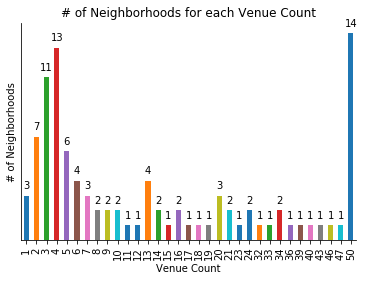

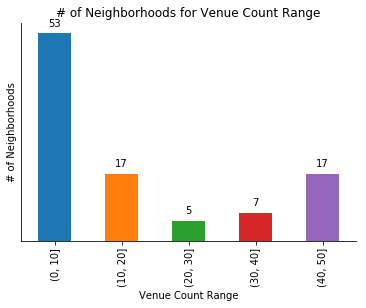

In [15]:
# Plot number of Neighborhoods for each Venue Count
vc='Venue Count by Neighborhood'
nc='# of Neighborhoods'
counted = grouped.groupby(vc).size().reset_index(name=nc).sort_values(by=vc,ascending=True)
ax = counted.plot(kind='bar', x=vc, y=nc, legend=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.title('# of Neighborhoods for each Venue Count')
plt.xlabel('Venue Count')
plt.ylabel(nc)
plt.yticks([])
for p in ax.patches:
    ax.annotate("%i" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.show()

# Plot number of Neighborhoods for Venue Count range
bins=np.arange(0,60,10)
vc_ranged = counted.rename(columns={vc:'VCR'}).groupby(pd.cut(counted[vc],bins)).sum().drop(columns='VCR').reset_index()
ax = vc_ranged.plot(kind='bar', x=vc, y=nc, legend=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.title('# of Neighborhoods for Venue Count Range')
plt.xlabel('Venue Count Range')
plt.ylabel(nc)
plt.yticks([])
for p in ax.patches:
    ax.annotate("%i" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.show()

9. Visualize the top 10 categories across the entire set of venues (all neighborhoods) and as well as the top 20 neighborhoods.

There are 255 uniques categories.


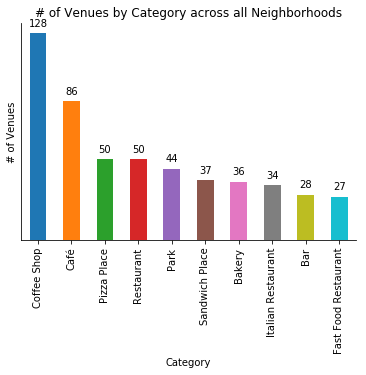

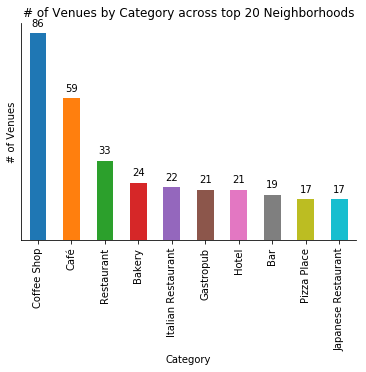

In [16]:
print('There are {} uniques categories.'.format(len(city_venues['Venue Category'].unique())))

top_categories_all = city_venues.groupby('Venue Category').size().reset_index(name='count').sort_values(by='count', ascending=False).reset_index(drop=True)[0:10]
vc='Venue Category'
nv='count'
ax = top_categories_all.plot(kind='bar', x=vc, y=nv, legend=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.title('# of Venues by Category across all Neighborhoods')
plt.xlabel('Category')
plt.ylabel('# of Venues')
plt.yticks([])
for p in ax.patches:
    ax.annotate("%i" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.show()

top_categories_top_neighborhoods = city_venues.join(top_neighborhoods,on='Neighborhood',how='inner').groupby('Venue Category').size().reset_index(name='count').sort_values(by='count', ascending=False).reset_index(drop=True)[0:10]
ax = top_categories_top_neighborhoods.plot(kind='bar', x=vc, y=nv, legend=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.title('# of Venues by Category across top 20 Neighborhoods')
plt.xlabel('Category')
plt.ylabel('# of Venues')
plt.yticks([])
for p in ax.patches:
    ax.annotate("%i" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.show()

10. One hot encode the data.

In [17]:
# one hot encoding
city_onehot = pd.get_dummies(city_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
city_onehot['Neighborhood'] = city_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [city_onehot.columns[-1]] + list(city_onehot.columns[:-1])
city_onehot = city_onehot[fixed_columns]

print('Dimensions of one hot encoded dataframe: {}'.format(city_onehot.shape))

city_grouped = city_onehot.groupby('Neighborhood').mean().reset_index()

print('Dimensions of one hot encoded dataframe grouped by Neighborhood: {}'.format(city_grouped.shape))

Dimensions of one hot encoded dataframe: (1692, 255)
Dimensions of one hot encoded dataframe grouped by Neighborhood: (99, 255)


In [18]:
# Print each neighborhood along with its respective top 5 most common venues (category) by frequency.
num_top_venues = 5

for hood in city_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = city_grouped[city_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide, King, Richmond----
            venue  freq
0      Steakhouse  0.06
1     Coffee Shop  0.06
2            Café  0.06
3  Breakfast Spot  0.04
4           Hotel  0.04


----Agincourt----
                venue  freq
0      Breakfast Spot  0.25
1              Lounge  0.25
2      Clothing Store  0.25
3        Skating Rink  0.25
4  Mexican Restaurant  0.00


----Agincourt North, L'Amoreaux East, Milliken, Steeles East----
               venue  freq
0         Playground   0.5
1               Park   0.5
2             Museum   0.0
3  Martial Arts Dojo   0.0
4     Massage Studio   0.0


----Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown----
                  venue  freq
0           Pizza Place  0.15
1         Grocery Store  0.15
2  Fast Food Restaurant  0.08
3           Coffee Shop  0.08
4   Japanese Restaurant  0.08


----Alderwood, Long Branch----
            venue  freq
0     Pizza Place  0.25
1             Pub  0.12
2

                 venue  freq
0       Discount Store   0.4
1     Department Store   0.2
2          Coffee Shop   0.2
3           Hobby Shop   0.2
4  Monument / Landmark   0.0


----East Toronto----
                venue  freq
0         Coffee Shop  0.33
1   Convenience Store  0.33
2                Park  0.33
3         Yoga Studio  0.00
4  Mexican Restaurant  0.00


----Emery, Humberlea----
            venue  freq
0  Baseball Field   1.0
1     Yoga Studio   0.0
2          Market   0.0
3  Massage Studio   0.0
4  Medical Center   0.0


----Fairview, Henry Farm, Oriole----
                  venue  freq
0        Clothing Store  0.16
1           Coffee Shop  0.08
2  Fast Food Restaurant  0.08
3         Women's Store  0.04
4   Sporting Goods Shop  0.04


----First Canadian Place, Underground city----
           venue  freq
0           Café  0.10
1    Coffee Shop  0.08
2  Deli / Bodega  0.06
3          Hotel  0.06
4     Restaurant  0.04


----Flemingdon Park, Don Mills South----
              v

               venue  freq
0         Playground   0.5
1  Convenience Store   0.5
2        Music Store   0.0
3     Massage Studio   0.0
4     Medical Center   0.0


----St. James Town----
                venue  freq
0         Coffee Shop  0.08
1          Restaurant  0.08
2           Gastropub  0.06
3  Italian Restaurant  0.06
4               Hotel  0.06


----Stn A PO Boxes 25 The Esplanade----
            venue  freq
0    Cocktail Bar  0.06
1            Café  0.06
2      Restaurant  0.06
3           Hotel  0.04
4  Farmers Market  0.04


----Studio District----
                 venue  freq
0                 Café  0.10
1          Coffee Shop  0.08
2            Gastropub  0.05
3               Bakery  0.05
4  American Restaurant  0.05


----The Annex, North Midtown, Yorkville----
               venue  freq
0     Sandwich Place  0.12
1        Coffee Shop  0.12
2               Café  0.12
3        Pizza Place  0.08
4  Jewish Restaurant  0.04


----The Beaches----
                       venue 

11. Create a DataFrame containing the top 10 venues by neighborhood based on the one hot encoded data and visualize the data.

In [19]:
# Create a function to sort the venues in descending order.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [20]:
# Call the function to populate the DataFrame with top 10 venues for each neighborhood
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = city_grouped['Neighborhood']

for ind in np.arange(city_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(city_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Steakhouse,Café,Restaurant,Breakfast Spot,Pizza Place,Gastropub,Asian Restaurant,Hotel,American Restaurant
1,Agincourt,Lounge,Clothing Store,Skating Rink,Breakfast Spot,Deli / Bodega,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Dog Run
2,"Agincourt North, L'Amoreaux East, Milliken, St...",Playground,Park,Curling Ice,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Dog Run,Dive Bar,Discount Store
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",Grocery Store,Pizza Place,Pharmacy,Beer Store,Japanese Restaurant,Fried Chicken Joint,Sandwich Place,Fast Food Restaurant,Discount Store,Video Store
4,"Alderwood, Long Branch",Pizza Place,Pharmacy,Coffee Shop,Pub,Sandwich Place,Skating Rink,Gym,Gastropub,Garden Center,Discount Store


In [21]:
print("1st Most Common Venue: {}".format(neighborhoods_venues_sorted['1st Most Common Venue'].describe().top))
print("2nd Most Common Venue: {}".format(neighborhoods_venues_sorted['2nd Most Common Venue'].describe().top))
print("3rd Most Common Venue: {}".format(neighborhoods_venues_sorted['3rd Most Common Venue'].describe().top))
print("4th Most Common Venue: {}".format(neighborhoods_venues_sorted['4th Most Common Venue'].describe().top))
print("5th Most Common Venue: {}".format(neighborhoods_venues_sorted['5th Most Common Venue'].describe().top))
print("6th Most Common Venue: {}".format(neighborhoods_venues_sorted['6th Most Common Venue'].describe().top))
print("7th Most Common Venue: {}".format(neighborhoods_venues_sorted['7th Most Common Venue'].describe().top))
print("8th Most Common Venue: {}".format(neighborhoods_venues_sorted['8th Most Common Venue'].describe().top))
print("9th Most Common Venue: {}".format(neighborhoods_venues_sorted['9th Most Common Venue'].describe().top))
print("10th Most Common Venue: {}".format(neighborhoods_venues_sorted['10th Most Common Venue'].describe().top))

1st Most Common Venue: Coffee Shop
2nd Most Common Venue: Coffee Shop
3rd Most Common Venue: Coffee Shop
4th Most Common Venue: Women's Store
5th Most Common Venue: Electronics Store
6th Most Common Venue: Eastern European Restaurant
7th Most Common Venue: Dumpling Restaurant
8th Most Common Venue: Drugstore
9th Most Common Venue: Dog Run
10th Most Common Venue: Dive Bar


### Analysis (Machine Learning)

12. Based on the data available for neighborhoods and venues, we can define venue categories as features for machine learning. Given there are approximately 166 categories across a data set of 99 neighborhoods, use of k-means clustering to cluster the neighborhoods sounds like a reasonable approach. The 166 categories naturally map to features used in the k-means model. An initial value of ‘k’ was set to 7 [square root of 49.5 (99 divided by 2)]. This generates the cluster labels for each of the neighborhoods.

In [22]:
# set number of clusters
kclusters = 7

city_grouped_clustering = city_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(city_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([5, 6, 4, 6, 2, 6, 5, 5, 5, 5])

13. Next, we combine the cluster labels into neighborhood and top 10 venue data set.

In [23]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

city_merged = neighborhoods

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
city_merged = city_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

# drop rows with no assigned clusters
city_merged.dropna(inplace=True)

city_merged.head() # check the last columns!

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,6.0,Fast Food Restaurant,Print Shop,Women's Store,Curling Ice,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Dog Run,Dive Bar,Discount Store
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,0.0,Bar,Golf Course,History Museum,Women's Store,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,6.0,Electronics Store,Rental Car Location,Spa,Medical Center,Breakfast Spot,Mexican Restaurant,Pizza Place,Concert Hall,Comfort Food Restaurant,College Gym
3,M1G,Scarborough,Woburn,43.770992,-79.216917,5.0,Coffee Shop,Korean Restaurant,Women's Store,Dance Studio,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Dog Run,Dive Bar
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,6.0,Athletics & Sports,Lounge,Hakka Restaurant,Fried Chicken Joint,Thai Restaurant,Bakery,Bank,Caribbean Restaurant,Diner,Dim Sum Restaurant


14. Visualize the resulting clusters on a map of Toronto using Folium.

In [24]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(city_merged['Latitude'], city_merged['Longitude'], city_merged['Neighborhood'], city_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    cluster = int(cluster)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Results<a name='results'></a>
In this section we examine the clusters and view cluster specific details.

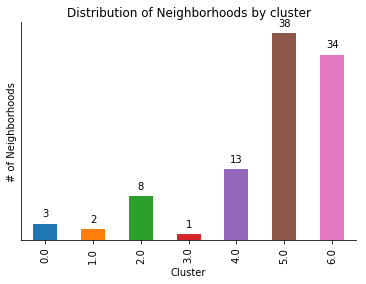

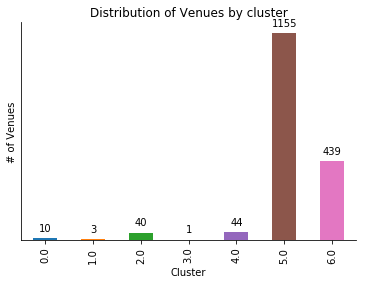

,Cluster Labels,Venue Category,Count
0,0.0,Bar,3
8,1.0,Baseball Field,2
26,2.0,Pizza Place,9
32,3.0,Garden,1
46,4.0,Park,15
99,5.0,Coffee Shop,105
309,6.0,Fast Food Restaurant,20


In [25]:
# Plot the distribution of neighborhoods across clusters
cn = city_merged.groupby('Cluster Labels').size().reset_index(name='# of Neighborhoods')
ax = cn.plot(kind='bar', x='Cluster Labels', y='# of Neighborhoods', legend=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.title('Distribution of Neighborhoods by cluster')
plt.xlabel('Cluster')
plt.ylabel('# of Neighborhoods')
plt.yticks([])
for p in ax.patches:
    ax.annotate("%i" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.show()

# Plot the distribution of venues across clusters
cv = city_venues.merge(city_merged, on='Neighborhood')[['Venue','Cluster Labels']].groupby('Cluster Labels').size().reset_index(name='# of Venues')
ax = cv.plot(kind='bar', x='Cluster Labels', y='# of Venues', legend=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.title('Distribution of Venues by cluster')
plt.xlabel('Cluster')
plt.ylabel('# of Venues')
plt.yticks([])
for p in ax.patches:
    ax.annotate("%i" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.show()

# Display most common venue category in each cluster
city_venues.merge(city_merged, on='Neighborhood')[['Cluster Labels','Venue Category']].groupby(['Cluster Labels','Venue Category']).size().reset_index(name='Count').sort_values(by=['Cluster Labels','Count'],ascending=[True,False]).groupby(['Cluster Labels']).head(1)

The plots above present the distribution of entire set of neighborhoods (99) and venues (1692) across 7 clusters.  Each cluster includes neighborhoods that have commonality based on the feature set which equates to the categories of the venues in the neighborhood. A key point to notice is the uneven distribution of the neighborhoods and venues across the clusters indicating the similarity or cohesiveness in the clusters 5 and 6.

Next, we look at the most common venue in each cluster. Coffee Shops and Fast Food Restaurants are the most common venues in clusters 5 and 6 respectively.

In [26]:
city_merged.loc[city_merged['Cluster Labels'] == 0, city_merged.columns[[1] + [2] + list(range(5, city_merged.shape[1]))]]

,Borough,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Scarborough,"Highland Creek, Rouge Hill, Port Union",0.0,Bar,Golf Course,History Museum,Women's Store,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run
29,North York,"Northwood Park, York University",0.0,Coffee Shop,Massage Studio,Caribbean Restaurant,Bar,Women's Store,Dive Bar,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store
102,Etobicoke,Northwest,0.0,Drugstore,Bar,Rental Car Location,Women's Store,Dance Studio,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Dog Run,Dive Bar


Cluster 0 has 3 neighborhoods which are geographically apart (Scarborough on the east, North York in the northcentral, and Etobicoke) with a suburban flavor, bars, coffee shops, open areas like golf course and dog run, and women’s stores.

In [27]:
city_merged.loc[city_merged['Cluster Labels'] == 1, city_merged.columns[[1] + [2] + list(range(5, city_merged.shape[1]))]]

,Borough,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
91,Etobicoke,"Humber Bay, King's Mill Park, Kingsway Park So...",1.0,Baseball Field,Construction & Landscaping,Women's Store,Deli / Bodega,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Dog Run
97,North York,"Emery, Humberlea",1.0,Baseball Field,Women's Store,Event Space,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Dog Run,Dive Bar


Cluster 1 has 2 neighborhoods which are in the same boroughs as cluster 0, and with similar characteristics. While outdoor spaces like Parks and Golf course are a common thread, the key difference is the Baseball Field which is a common thread in this cluster.

In [28]:
city_merged.loc[city_merged['Cluster Labels'] == 2, city_merged.columns[[1] + [2] + list(range(5, city_merged.shape[1]))]]

,Borough,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,Scarborough,"Clarks Corners, Sullivan, Tam O'Shanter",2.0,Pizza Place,Pharmacy,Fast Food Restaurant,Italian Restaurant,Thai Restaurant,Fried Chicken Joint,Chinese Restaurant,Noodle House,Discount Store,Curling Ice
24,North York,Willowdale West,2.0,Grocery Store,Coffee Shop,Butcher,Pharmacy,Pizza Place,College Stadium,Comfort Food Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant
31,North York,Downsview West,2.0,Grocery Store,Bank,Hotel,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dance Studio
81,York,"The Junction North, Runnymede",2.0,Grocery Store,Convenience Store,Bus Line,Pizza Place,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Dog Run,Dance Studio
89,Etobicoke,"Alderwood, Long Branch",2.0,Pizza Place,Pharmacy,Coffee Shop,Pub,Sandwich Place,Skating Rink,Gym,Gastropub,Garden Center,Discount Store
94,Etobicoke,"Cloverdale, Islington, Martin Grove, Princess ...",2.0,Bank,Women's Store,Event Space,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Dog Run,Dive Bar
96,North York,Humber Summit,2.0,Empanada Restaurant,Pizza Place,Curling Ice,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Dog Run,Dive Bar,Discount Store
99,Etobicoke,Westmount,2.0,Pizza Place,Playground,Middle Eastern Restaurant,Sandwich Place,Chinese Restaurant,Coffee Shop,Dog Run,Dive Bar,Discount Store,Diner


Cluster 2 has 8 neighborhoods that are geographically apart like cluster 0. Pizza Place and Grocery Stores are the most common venues.

In [29]:
city_merged.loc[city_merged['Cluster Labels'] == 3, city_merged.columns[[1] + [2] + list(range(5, city_merged.shape[1]))]]

,Borough,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
63,Central Toronto,Roselawn,3.0,Garden,Women's Store,Dance Studio,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Dog Run,Dive Bar


Cluster 3 has 1 neighborhood which indicates characteristics that are unique to the venue categories. It also indicates that the neighborhood is small and does not have enough venues to fit other clusters.

In [30]:
city_merged.loc[city_merged['Cluster Labels'] == 4, city_merged.columns[[1] + [2] + list(range(5, city_merged.shape[1]))]]

,Borough,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,Scarborough,"Agincourt North, L'Amoreaux East, Milliken, St...",4.0,Playground,Park,Curling Ice,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Dog Run,Dive Bar,Discount Store
23,North York,York Mills West,4.0,Park,Bank,Women's Store,Dance Studio,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Dog Run,Dive Bar
25,North York,Parkwoods,4.0,Bus Stop,Food & Drink Shop,Fast Food Restaurant,Park,Diner,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Dive Bar
30,North York,"CFB Toronto, Downsview East",4.0,Airport,Park,Bus Stop,Women's Store,Discount Store,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner
40,East York,East Toronto,4.0,Convenience Store,Coffee Shop,Park,Women's Store,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run
44,Central Toronto,Lawrence Park,4.0,Bus Line,Park,Swim School,Discount Store,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Women's Store
50,Downtown Toronto,Rosedale,4.0,Park,Playground,Trail,Diner,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Discount Store
64,Central Toronto,"Forest Hill North, Forest Hill West",4.0,Bus Line,Trail,Park,Sushi Restaurant,Jewelry Store,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner
74,York,Caledonia-Fairbanks,4.0,Park,Women's Store,Market,Pharmacy,Fast Food Restaurant,Diner,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant
79,North York,"Maple Leaf Park, North Park, Upwood Park",4.0,Park,Basketball Court,Construction & Landscaping,Bakery,Women's Store,Dog Run,Dim Sum Restaurant,Diner,Discount Store,Dive Bar


Cluster 4 has 13 neighborhoods which cover most of the boroughs. A common thread is the number of parks, playgrounds, and trails around the Don River Valley. Access to public transportation such as Bus Line is a key feature. Restaurants serving multi-cultural cuisine is common in this cluster.

In [31]:
city_merged.loc[city_merged['Cluster Labels'] == 5, city_merged.columns[[1] + [2] + list(range(5, city_merged.shape[1]))]]

,Borough,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Scarborough,Woburn,5.0,Coffee Shop,Korean Restaurant,Women's Store,Dance Studio,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Dog Run,Dive Bar
6,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",5.0,Discount Store,Hobby Shop,Coffee Shop,Department Store,Dive Bar,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Women's Store
8,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",5.0,Movie Theater,American Restaurant,Motel,Women's Store,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Dog Run,Dive Bar
9,Scarborough,"Birch Cliff, Cliffside West",5.0,College Stadium,Café,Skating Rink,General Entertainment,Women's Store,Discount Store,Department Store,Dessert Shop,Dim Sum Restaurant,Diner
19,North York,Bayview Village,5.0,Chinese Restaurant,Café,Japanese Restaurant,Bank,Women's Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Deli / Bodega
22,North York,Willowdale South,5.0,Ramen Restaurant,Pizza Place,Coffee Shop,Sandwich Place,Café,Restaurant,Pet Store,Hotel,Steakhouse,Ice Cream Shop
26,North York,Don Mills North,5.0,Café,Baseball Field,Gym / Fitness Center,Japanese Restaurant,Caribbean Restaurant,Basketball Court,Dim Sum Restaurant,Diner,Discount Store,Dive Bar
34,North York,Victoria Village,5.0,Grocery Store,Hockey Arena,Coffee Shop,Portuguese Restaurant,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store
37,East Toronto,The Beaches,5.0,Pub,Coffee Shop,Health Food Store,Dive Bar,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store
41,East Toronto,"The Danforth West, Riverdale",5.0,Greek Restaurant,Coffee Shop,Ice Cream Shop,Bookstore,Italian Restaurant,Yoga Studio,Spa,Indian Restaurant,Dessert Shop,Sports Bar


Cluster 5 is the largest cluster with 38 neighborhoods and includes 1155 venues. It covers most of the boroughs. Although the most common venue is Coffee Shops and Cafes, this cluster has a wide coverage of restaurants serving multi-cultural cuisine.

In [32]:
city_merged.loc[city_merged['Cluster Labels'] == 6, city_merged.columns[[1] + [2] + list(range(5, city_merged.shape[1]))]]

,Borough,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Scarborough,"Rouge, Malvern",6.0,Fast Food Restaurant,Print Shop,Women's Store,Curling Ice,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Dog Run,Dive Bar,Discount Store
2,Scarborough,"Guildwood, Morningside, West Hill",6.0,Electronics Store,Rental Car Location,Spa,Medical Center,Breakfast Spot,Mexican Restaurant,Pizza Place,Concert Hall,Comfort Food Restaurant,College Gym
4,Scarborough,Cedarbrae,6.0,Athletics & Sports,Lounge,Hakka Restaurant,Fried Chicken Joint,Thai Restaurant,Bakery,Bank,Caribbean Restaurant,Diner,Dim Sum Restaurant
5,Scarborough,Scarborough Village,6.0,Playground,Convenience Store,Dance Studio,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Dog Run,Dive Bar
7,Scarborough,"Clairlea, Golden Mile, Oakridge",6.0,Bus Line,Bakery,Fast Food Restaurant,Intersection,Metro Station,Bus Station,Soccer Field,Park,Drugstore,Dog Run
10,Scarborough,"Dorset Park, Scarborough Town Centre, Wexford ...",6.0,Indian Restaurant,Chinese Restaurant,Pet Store,Latin American Restaurant,Vietnamese Restaurant,Dive Bar,Department Store,Dessert Shop,Dim Sum Restaurant,Diner
11,Scarborough,"Maryvale, Wexford",6.0,Middle Eastern Restaurant,Breakfast Spot,Shopping Mall,Sandwich Place,Auto Garage,Women's Store,Deli / Bodega,Dumpling Restaurant,Drugstore,Dog Run
12,Scarborough,Agincourt,6.0,Lounge,Clothing Store,Skating Rink,Breakfast Spot,Deli / Bodega,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Dog Run
15,Scarborough,"L'Amoreaux West, Steeles West",6.0,Fast Food Restaurant,Chinese Restaurant,Gym,Breakfast Spot,Electronics Store,Noodle House,Pharmacy,Pizza Place,Coffee Shop,Sandwich Place
17,North York,Hillcrest Village,6.0,Mediterranean Restaurant,Golf Course,Pool,Dog Run,Discount Store,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner


Cluster 6 is the second largest cluster with 34 neighborhoods and includes 439 venues. Like cluster 5, it covers most of the boroughs. The most common venues is Fast Food Restaurant. Apart from restaurants, this cluster includes a wide range of retails outlets.

## Discussion<a name='discussion'></a>
I observed the following during the analysis of the results:
1.	Predominance of 2 clusters across the neighborhoods and venue categories which indicates similarity or commonality of features. The remaining 4 clusters had more distinguishing or unique features.
2.	The k-means clustering approach relied of frequency of a category across the 255 unique categories. The feature set may be large compared to the number of samples, i.e. number of neighborhoods (99).
3.	I tried multiple values of k in the k-means clustering. For lower values of k, the larger clusters coalesced into a single cluster. For higher values of k, the number of smaller clusters increased but the larger clusters did not break up noticeably any further.
4.	The Foursquare data is primarily social and is crowdsourced. I noticed the API calls returned slightly different data sets when executed at various times of the day or day of the week.

Based on the results, I have the following recommendations:
1.	I had planned initially to use the Premium Endpoint to fetch ratings but was unable to because of the daily limits of API calls. This extended data could have provided a social dimension, but the data would change frequently.
2.	Running the analysis and comparing results over a period as opposed to a snapshot would stabilize the findings.
3.	Consider other unsupervised learning methods for comparative analysis.
4.	Augment demographic data for neighborhoods to get additional insights.

## Conclusion<a name='conclusion'></a>
In conclusion, this study was a positive step for the stakeholders to understand how data from various sources can be used via powerful tools and visualization techniques to derive insights.

From a personal perspective, it provided me with exposure to the data science methodology from a business problem, analysis, data acquisition, preparation, feature selection, model creation, train/fit and test/analyze results. The libraries for data acquisition, preparation, and visualization demonstrated the value of data science.